*   Author: Priyanshi Yadav
*   Course: AAI-595
*   Final file for implementation of Hierarchical Neural Network.
*   This file contains the model definition and compilation with hyperparameters.

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the dataset
data1 = pd.read_csv("./project_eda.csv")
data1.info

<bound method DataFrame.info of                                                Indicator              Group  \
0      Took Prescription Medication for Mental Health...  National Estimate   
1      Took Prescription Medication for Mental Health...             By Age   
2      Took Prescription Medication for Mental Health...             By Age   
3      Took Prescription Medication for Mental Health...             By Age   
4      Took Prescription Medication for Mental Health...             By Age   
...                                                  ...                ...   
10399  Needed Counseling or Therapy But Did Not Get I...           By State   
10400  Needed Counseling or Therapy But Did Not Get I...           By State   
10401  Needed Counseling or Therapy But Did Not Get I...           By State   
10402  Needed Counseling or Therapy But Did Not Get I...           By State   
10403  Needed Counseling or Therapy But Did Not Get I...           By State   

               State       Subgroup Phase  Time Period      Time Period Label  \
0      United States  United States     2           13  Aug 19 - Aug 31, 2020   
1      United States  18 - 29 years     2           13  Aug 19 - Aug 31, 2020   
2      United States  30 - 39 years     2           13  Aug 19 - Aug 31, 2020   
3      United States  40 - 49 years     2           13  Aug 19 - Aug 31, 2020   
4      United States  50 - 59 years     2           13  Aug 19 - Aug 31, 2020   
...              ...            ...   ...          ...                    ...   
10399       Virginia       Virginia   3.4           45   Apr 27 - May 9, 2022   
10400     Washington     Washington   3.4           45   Apr 27 - May 9, 2022   
10401  West Virginia  West Virginia   3.4           45   Apr 27 - May 9, 2022   
10402      Wisconsin      Wisconsin   3.4           45   Apr 27 - May 9, 2022   
10403        Wyoming        Wyoming   3.4           45   Apr 27 - May 9, 2022   

       Value  LowCI  HighCI Quartile Range Usage_Category  
0       19.4   19.0    19.8       9.8-11.2         Medium  
1       18.7   17.2    20.3       9.8-11.2         Medium  
2       18.3   17.3    19.2       9.8-11.2         Medium  
3       20.4   19.5    21.3       9.8-11.2         Medium  
4       21.2   20.2    22.2       9.8-11.2         Medium  
...      ...    ...     ...            ...            ...  
10399   10.1    7.1    13.8       9.6-11.3            Low  
10400   14.8   12.5    17.4      13.0-20.8         Medium  
10401    9.8    6.6    13.8       9.6-11.3            Low  
10402   11.6    8.5    15.3      11.4-12.9            Low  
10403   11.5    8.6    15.1      11.4-12.9            Low  

[10404 rows x 12 columns]>

In [3]:
# Making a copy of dataset for performing data preprocessing
data = data1.copy()

In [4]:
# Identify categorical columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns.to_list()
print("Categorical Columns: ", cat_cols)

# Numerical variables:
num_cols = data.select_dtypes(include = ['float', 'int']).columns.to_list()
print("Numerical Columns: ",num_cols)

Categorical Columns:  ['Indicator', 'Group', 'State', 'Subgroup', 'Phase', 'Time Period Label', 'Quartile Range', 'Usage_Category']
Numerical Columns:  ['Time Period', 'Value', 'LowCI', 'HighCI']


In [5]:
# Group by on column Group and list all unique Subgroup classes belongs to each Group class
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
associations = data.groupby('Group')['Subgroup'].apply(lambda x: list(x.unique()))

# Display associations
print(associations)

Group
By Age                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [18 - 29 years, 30 - 39 years, 40 - 49 years, 50 - 59 years, 60 - 69 years, 70 - 79 years, 80 years and above]
By Disability status                                                                                                                                                                                                                                                                                                                                                                                            

In [6]:
# Identifying class distribution in Group and Subgroup
group_counts = data['Group'].value_counts()
subgroup_counts = data['Subgroup'].value_counts()

In [7]:
# Resampling the dataset using Upsampling and Downsampling
def balance_data(data, column, target_count):
    balanced_data = pd.DataFrame()
    for label in data[column].unique():
        subset = data[data[column] == label]
        if len(subset) < target_count:  # Upsample
            subset = resample(
                subset,
                replace=True,
                n_samples=target_count - len(subset),
                random_state=42,
            )
        elif len(subset) > target_count:  # Downsample
            subset = subset.sample(n=target_count, random_state=42)
        balanced_data = pd.concat([balanced_data, subset], axis=0)
    return balanced_data

The function above balances the dataset by performing upsampling or downsampling on the "Group" and "Subgroup" columns. First, it balances the "Group" classes based on the mean count, then for each group, it balances the "Subgroup" classes similarly.

In [8]:
# Set a target count for balance (here, using mean of counts)
target_group_count = int(group_counts.mean())
target_subgroup_count = int(subgroup_counts.mean())

In [9]:
# Calling Balance Group function for Group column
balanced_group_data = balance_data(data, 'Group', target_group_count)

In [10]:
# Balancing Subgroup classes present within each Group class
balanced_data = pd.DataFrame()
for group in balanced_group_data['Group'].unique():
    group_data = balanced_group_data[balanced_group_data['Group'] == group]
    balanced_group_subgroup_data = balance_data(group_data, 'Subgroup', target_subgroup_count)
    balanced_data = pd.concat([balanced_data, balanced_group_subgroup_data], axis=0)

group_counts = balanced_data['Group'].value_counts()
print("Group Class Balance:\n", group_counts)

subgroup_counts = balanced_data['Subgroup'].value_counts()
print("Subgroup Class Balance:\n", subgroup_counts)

Group Class Balance:
 Group
By State                                         5590
By Age                                            910
By Gender identity                                390
By Sexual orientation                             390
By Race/Hispanic ethnicity                        370
By Sex                                            260
By Presence of Symptoms of Anxiety/Depression     260
By Disability status                              260
National Estimate                                 130
By Education                                       88
Name: count, dtype: int64
Subgroup Class Balance:
 Subgroup
United States                                                 130
Experienced symptoms of anxiety/depression in past 4 weeks    130
Bisexual                                                      130
Gay or lesbian                                                130
Cis-gender female                                             130
                                          

The resulting balanced dataset is stored in balanced_data which we have copied below in data variable.

In [11]:
# Updating the dataframe
data = balanced_data.copy()

In [12]:
# Defining the features and target variables
X = data.drop(columns=['Usage_Category', 'Group', 'Subgroup'], axis=1)
y_usage_category = data['Usage_Category']
y_group = data['Group']
y_subgroup = data['Subgroup']

In [13]:
print(X.columns)

Index(['Indicator', 'State', 'Phase', 'Time Period', 'Time Period Label',
       'Value', 'LowCI', 'HighCI', 'Quartile Range'],
      dtype='object')


In [14]:
# Encoding the categorical features using on-hot encoding
X = pd.get_dummies(X, columns=['Indicator', 'State', 'Phase', 'Time Period Label', 'Quartile Range'])

# Encoding the targets using the label encoding
le_usage = LabelEncoder()
y_usage_category = le_usage.fit_transform(y_usage_category)

le_group = LabelEncoder()
y_by_group = le_group.fit_transform(y_group)

le_subgroup = LabelEncoder()
y_subgroup = le_subgroup.fit_transform(y_subgroup)

In [15]:
# Scaling numerical features
scaler = MinMaxScaler()
X[['Time Period', 'Value', 'LowCI', 'HighCI']] = scaler.fit_transform(X[['Time Period', 'Value', 'LowCI', 'HighCI']])

In [16]:
# Split data into training and testing for each target variable
y_combined = pd.DataFrame({
    'Group': y_by_group,
    'Subgroup': y_subgroup
})
# Creating a new column to combine Group and Subgroup, this will be used for stratified sampling
y_combined['Group_Subgroup'] = y_combined['Group'].astype(str) + '_' + y_combined['Subgroup'].astype(str)

X_train, X_test, y_train_usage, y_test_usage = train_test_split(X, y_usage_category, test_size=0.2, stratify=y_combined, random_state=42)
_, _, y_train_group, y_test_group = train_test_split(X, y_by_group, test_size=0.2, stratify=y_combined, random_state=42)
_, _, y_train_subgroup, y_test_subgroup = train_test_split(X, y_subgroup, test_size=0.2, stratify=y_combined, random_state=42)

In [17]:
"""
# Define the hyperparameter grid
param_grid = {
    "dropout_rate": [0.3, 0.5],
    "l1_l2_reg": [(0.001, 0.001), (0.0001, 0.0001)],
    "batch_size": [32, 64]
}
best_params = None
best_accuracy = 0

# Loop over each combination of hyperparameters
for params in ParameterGrid(param_grid):
    print(f"Testing hyperparameters: {params}")
"""
# Using above params, I run the below code and got the following params as best performers:
# Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.3, 'l1_l2_reg': (0.001, 0.001)}
# Thus using them directly as the execution was taking around 2 hrs.

'\n# Define the hyperparameter grid\nparam_grid = {\n    "dropout_rate": [0.3, 0.5],\n    "l1_l2_reg": [(0.001, 0.001), (0.0001, 0.0001)],\n    "batch_size": [32, 64]\n}\nbest_params = None\nbest_accuracy = 0\n\n# Loop over each combination of hyperparameters\nfor params in ParameterGrid(param_grid):\n    print(f"Testing hyperparameters: {params}")\n'

Using above params, I run the below code and got the following params as best performers:
Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.3, 'l1_l2_reg': (0.001, 0.001)}
Thus using them directly as the execution was taking around 2 hrs.

In [18]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize storage for loss history and fold metrics
loss_history = {'train_usage': [], 'val_usage': [],
                'train_group': [], 'val_group': [],
                'train_subgroup': [], 'val_subgroup': []}
# Initialize storage for fold metrics
fold_metrics = {'train_usage': [], 'val_usage': [],
                'train_group': [], 'val_group': [],
                'train_subgroup': [], 'val_subgroup': []}

# Arrays to store performance metrics
fold_accuracies_usage = []
fold_accuracies_group = []
fold_accuracies_subgroup = []

Initializing the folds value for cross validation and and storing loss and fold metrics for plotting purpose.

In [19]:
# Loop through the folds
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train_usage)):  # Using y_train_usage for stratification
    print(f"Training on fold {fold+1}/{k_folds}: ")

    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_usage_fold, y_val_usage_fold = y_train_usage[train_idx], y_train_usage[val_idx]
    y_train_group_fold, y_val_group_fold = y_train_group[train_idx], y_train_group[val_idx]
    y_train_subgroup_fold, y_val_subgroup_fold = y_train_subgroup[train_idx], y_train_subgroup[val_idx]

    # Define and compile your HNN model as you did
    # Shared input layer
    input_layer = layers.Input(shape=(X_train.shape[1],))

    # Apply ElasticNet regularization to the layers
    elasticnet_reg = L1L2(l1=0.001, l2=0.001)

    # Shared feature extraction layers
    shared = layers.Dense(128, activation='relu')(input_layer)
    shared = layers.BatchNormalization()(shared)  # Normalize activations
    shared = layers.Dropout(0.2)(shared)
    shared = layers.Dense(64, activation='relu')(shared)

    # Usage Category Branch
    usage_branch = layers.Dense(32, activation='relu')(shared)
    usage_output = layers.Dense(len(le_usage.classes_), activation='softmax', name='usage_category')(usage_branch)

    # By Group Branch
    group_input = layers.Concatenate()([shared, usage_output])
    group_branch = layers.Dense(32, activation='relu')(group_input)
    group_branch = layers.Dropout(0.3)(group_branch)
    group_branch2 = layers.Dense(16, activation='relu')(group_branch)
    group_output = layers.Dense(len(le_group.classes_), activation='softmax', name='by_group')(group_branch2)

    # Subgroup Branch
    subgroup_input = layers.Concatenate()([shared, usage_output, group_output])
    subgroup_branch = layers.Dense(32, activation='relu')(subgroup_input)
    subgroup_branch2 = layers.Dense(16, activation='relu')(subgroup_branch)
    subgroup_output = layers.Dense(len(le_subgroup.classes_), activation='softmax', name='subgroup')(subgroup_branch2)

    # Model
    model = models.Model(inputs=input_layer, outputs=[usage_output, group_output, subgroup_output])

    # Compile the model
    model.compile(optimizer='Adam',
                  loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
                  metrics=['accuracy', 'accuracy', 'accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Train the model
    history = model.fit(
        X_train_fold,
        [y_train_usage_fold, y_train_group_fold, y_train_subgroup_fold],
        validation_data=(X_val_fold, [y_val_usage_fold, y_val_group_fold, y_val_subgroup_fold]),
        epochs=50,
        callbacks=[early_stopping, lr_scheduler],
        batch_size=32,
        verbose=1
    )

    # Evaluate the model
    scores = model.evaluate(X_val_fold, [y_val_usage_fold, y_val_group_fold, y_val_subgroup_fold], verbose=0)
    fold_accuracies_usage.append(scores[6])
    fold_accuracies_group.append(scores[4])
    fold_accuracies_subgroup.append(scores[5])

    # Capture training metrics (last epoch's accuracy)
    fold_metrics['train_usage'].append(history.history['usage_category_accuracy'][-1])
    fold_metrics['train_group'].append(history.history['by_group_accuracy'][-1])
    fold_metrics['train_subgroup'].append(history.history['subgroup_accuracy'][-1])

    # Capture testing metrics
    fold_metrics['val_usage'].append(scores[6])  # Usage accuracy
    fold_metrics['val_group'].append(scores[4])  # Group accuracy
    fold_metrics['val_subgroup'].append(scores[5])  # Subgroup accuracy

    # Store loss history
    loss_history['train_usage'].extend(history.history['usage_category_loss'])
    loss_history['val_usage'].extend(history.history['val_usage_category_loss'])
    loss_history['train_group'].extend(history.history['by_group_loss'])
    loss_history['val_group'].extend(history.history['val_by_group_loss'])
    loss_history['train_subgroup'].extend(history.history['subgroup_loss'])
    loss_history['val_subgroup'].extend(history.history['val_subgroup_loss'])

# Compute mean and standard deviation of accuracies
mean_accuracy_usage = np.mean(fold_accuracies_usage)
std_accuracy_usage = np.std(fold_accuracies_usage)
print(f"Usage Accuracy: {mean_accuracy_usage:.4f} ± {std_accuracy_usage:.4f}")
mean_accuracy_group = np.mean(fold_accuracies_group)
std_accuracy_group = np.std(fold_accuracies_group)
print(f"Group Accuracy: {mean_accuracy_group:.4f} ± {std_accuracy_group:.4f}")
mean_accuracy_subgroup = np.mean(fold_accuracies_subgroup)
std_accuracy_subgroup = np.std(fold_accuracies_subgroup)
print(f"Subgroup Accuracy: {mean_accuracy_subgroup:.4f} ± {std_accuracy_subgroup:.4f}")

Training on fold 1/5: 
Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - by_group_accuracy: 0.5421 - by_group_loss: 1.4131 - loss: 6.4902 - subgroup_accuracy: 0.0267 - subgroup_loss: 4.2913 - usage_category_accuracy: 0.6293 - usage_category_loss: 0.7858 - val_by_group_accuracy: 0.7218 - val_by_group_loss: 0.9101 - val_loss: 5.4015 - val_subgroup_accuracy: 0.1879 - val_subgroup_loss: 3.8739 - val_usage_category_accuracy: 0.8331 - val_usage_category_loss: 0.6098 - learning_rate: 0.0010
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - by_group_accuracy: 0.7511 - by_group_loss: 0.7247 - loss: 3.5164 - subgroup_accuracy: 0.3695 - subgroup_loss: 2.5503 - usage_category_accuracy: 0.9024 - usage_category_loss: 0.2415 - val_by_group_accuracy: 0.7710 - val_by_group_loss: 0.7086 - val_loss: 2.5488 - val_subgroup_accuracy: 0.6626 - val_subgroup_loss: 1.5862 - val_usage_category_accuracy: 0.9184 - val_usage_category_loss: 0.2502 - learning_rate: 0.0010
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━

This model includes enhanced layers from initial model. It also has additional dense layers with increased depth (e.g., 128 and 64 units), with the group and subgroup branches further refined using multiple dense layers. Hyperparameters used are ElasticNet regularization, batch normalization, and dropout.

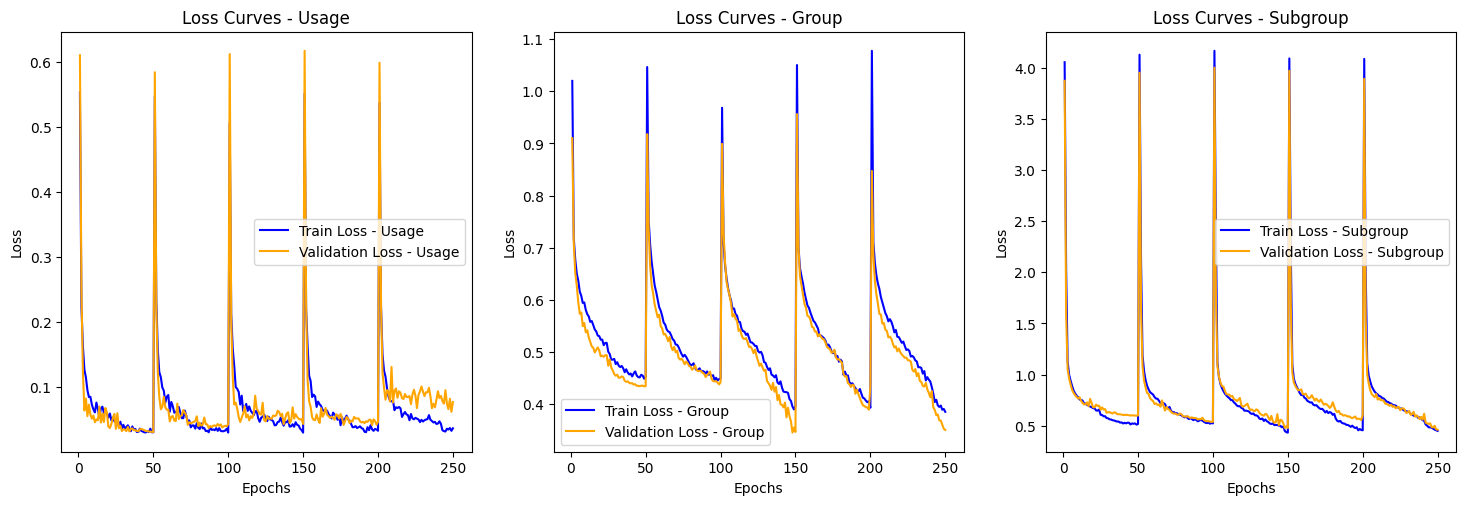

In [20]:
# Plotting both training, validation losses and testing accuracies
plt.figure(figsize=(18, 12))

# Plot for Loss Curves for Usage
plt.subplot(2, 3, 1)
epochs = range(1, len(loss_history['train_usage']) + 1)
plt.plot(epochs, loss_history['train_usage'], label='Train Loss - Usage', color='blue')
plt.plot(epochs, loss_history['val_usage'], label='Validation Loss - Usage', color='orange')
plt.title('Loss Curves - Usage')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Loss Curves for Group
plt.subplot(2, 3, 2)
plt.plot(epochs, loss_history['train_group'], label='Train Loss - Group', color='blue')
plt.plot(epochs, loss_history['val_group'], label='Validation Loss - Group', color='orange')
plt.title('Loss Curves - Group')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for Loss Curves for Subgroup
plt.subplot(2, 3, 3)
plt.plot(epochs, loss_history['train_subgroup'], label='Train Loss - Subgroup', color='blue')
plt.plot(epochs, loss_history['val_subgroup'], label='Validation Loss - Subgroup', color='orange')
plt.title('Loss Curves - Subgroup')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [21]:
# Evaluating the model on the test dataset
test_scores = model.evaluate(X_test, [y_test_usage, y_test_group, y_test_subgroup], verbose=1)
#print(test_scores)
# Display the evaluation results
print(f"Test Loss: {test_scores[0]:.4f}")
print(f"Test Usage Accuracy: {test_scores[6]:.4f}")
print(f"Test Group Accuracy: {test_scores[4]:.4f}")
print(f"Test Subgroup Accuracy: {test_scores[5]:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - by_group_accuracy: 0.8758 - by_group_loss: 0.3449 - loss: 0.8938 - subgroup_accuracy: 0.8403 - subgroup_loss: 0.4696 - usage_category_accuracy: 0.9849 - usage_category_loss: 0.0790
Test Loss: 0.8391
Test Usage Accuracy: 0.9838
Test Group Accuracy: 0.8717
Test Subgroup Accuracy: 0.8526


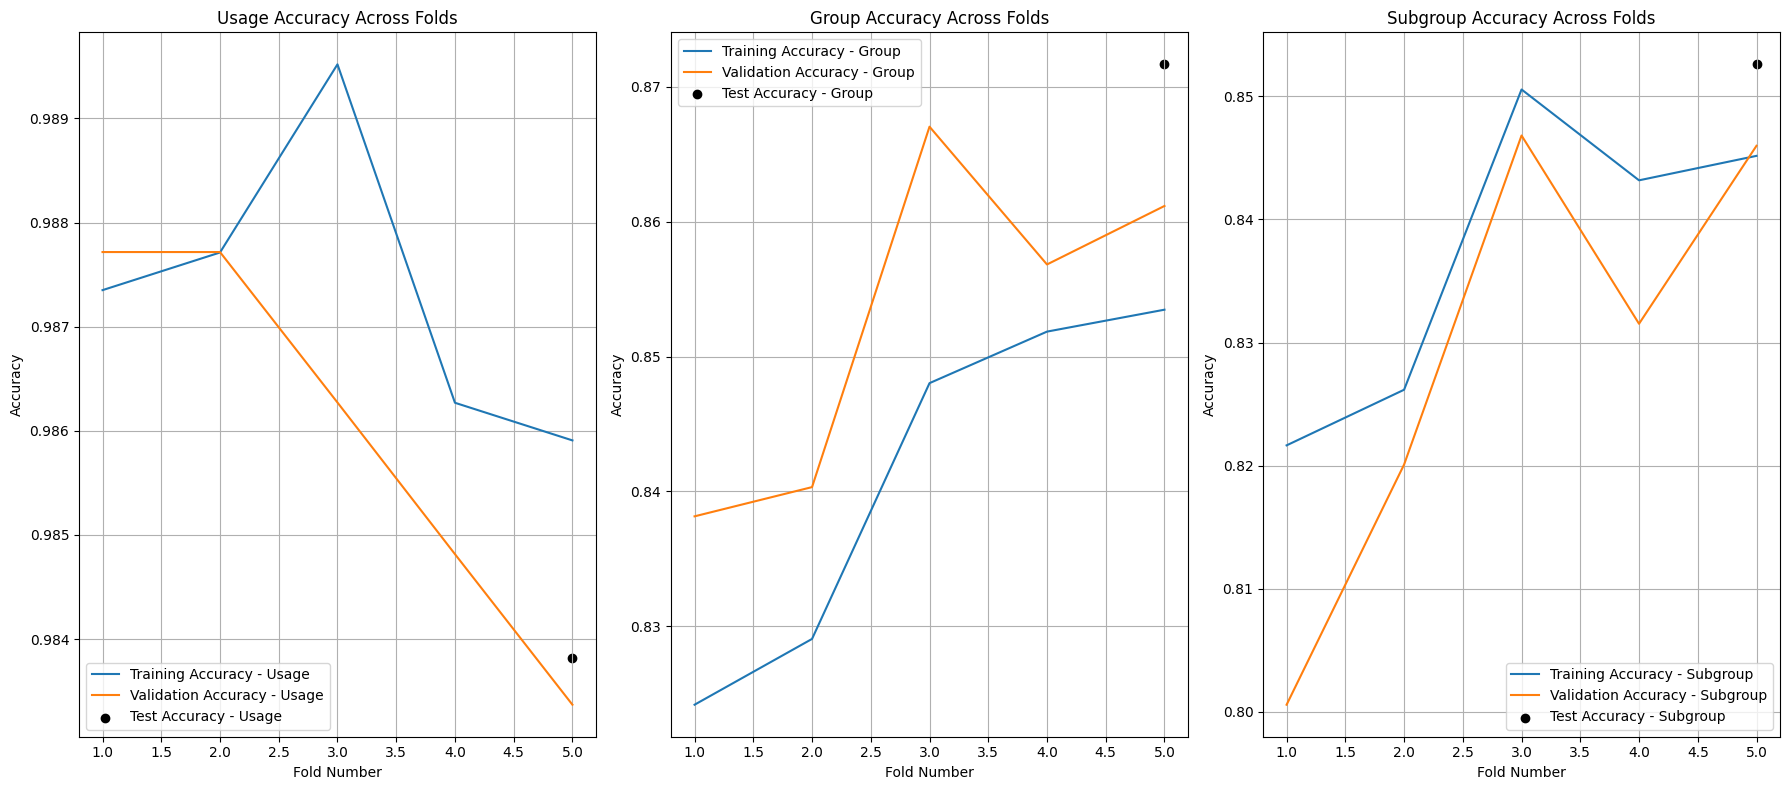

In [22]:
# Plotting accuracies for all folds
metrics = ['usage', 'group', 'subgroup']
fold_numbers = range(1, k_folds + 1)

plt.figure(figsize=(18, 8))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    plt.plot(fold_numbers, fold_metrics[f'train_{metric}'], label=f'Training Accuracy - {metric.capitalize()}')
    plt.plot(fold_numbers, fold_metrics[f'val_{metric}'], label=f'Validation Accuracy - {metric.capitalize()}')

    plt.scatter(k_folds, test_scores[6] if metric == 'usage' else (test_scores[4] if metric == 'group' else test_scores[5]),
                color='black', marker='o', label=f'Test Accuracy - {metric.capitalize()}')

    plt.title(f'{metric.capitalize()} Accuracy Across Folds')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
# Predicting on test dataset
predictions = model.predict(X_test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [24]:
# Extracting predictions for each target
usage_preds = np.argmax(predictions[0], axis=1)
group_preds = np.argmax(predictions[1], axis=1)
subgroup_preds = np.argmax(predictions[2], axis=1)

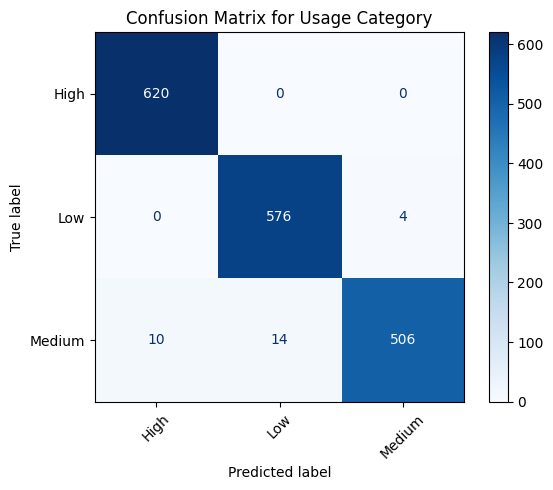

In [25]:
# Confusion Matrix for Usage Category
cm_usage = confusion_matrix(y_test_usage, usage_preds)
disp_usage = ConfusionMatrixDisplay(confusion_matrix=cm_usage, display_labels=le_usage.classes_)
disp_usage.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Usage Category")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()


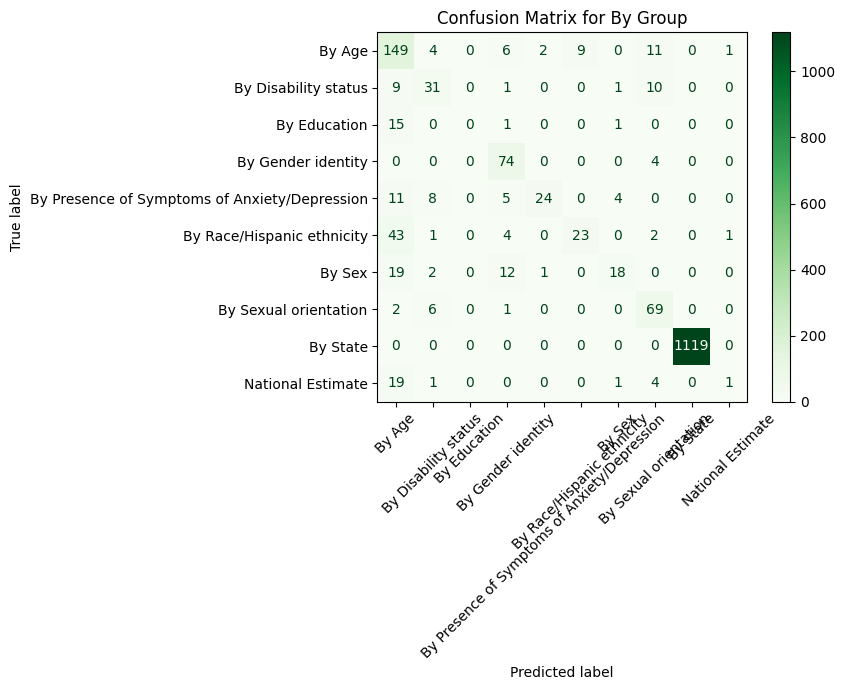

In [26]:
# Confusion Matrix for By Group
cm_group = confusion_matrix(y_test_group, group_preds)
disp_group = ConfusionMatrixDisplay(confusion_matrix=cm_group, display_labels=le_group.classes_)
disp_group.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix for By Group")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

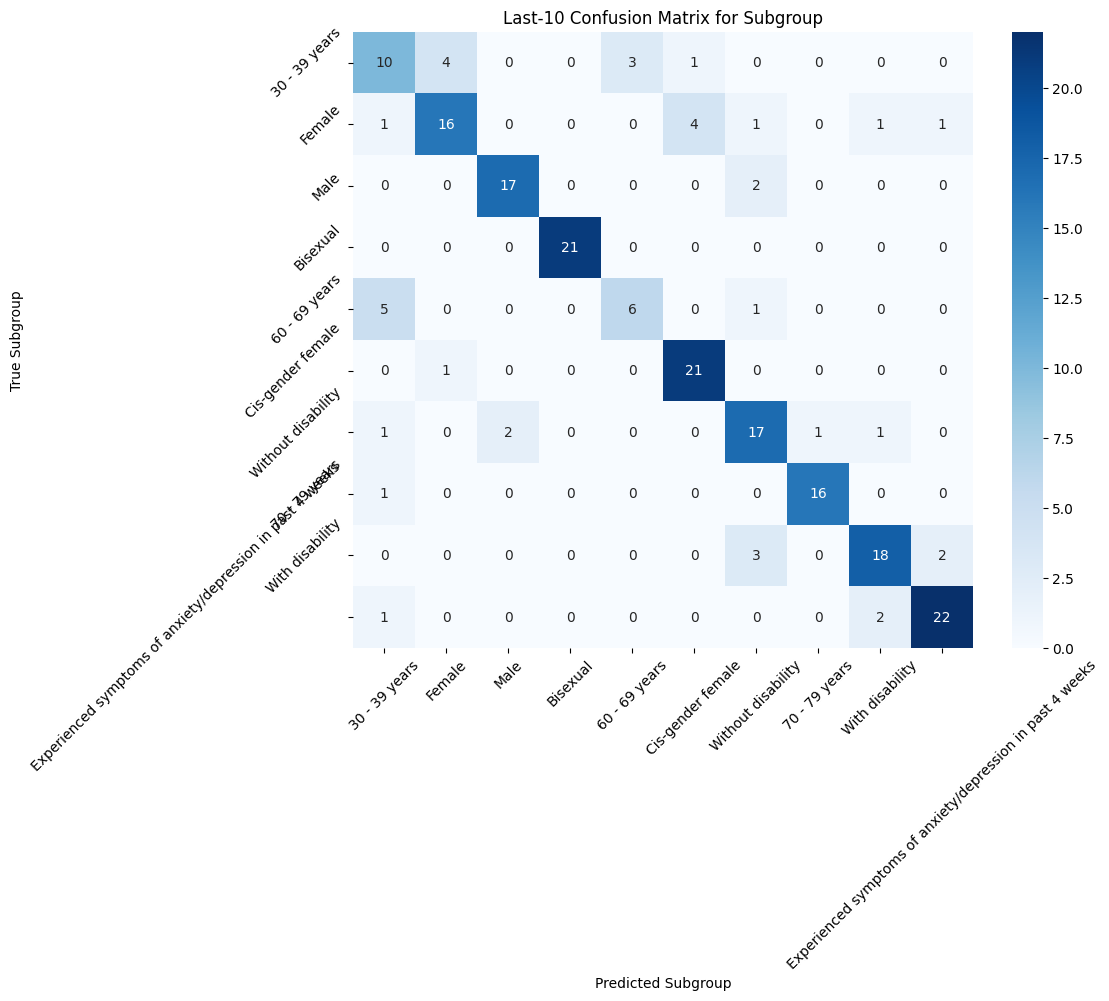

In [27]:
# Confusion Matrix for Subgroup
cm_subgroup = confusion_matrix(y_test_subgroup, subgroup_preds)
cm_df = pd.DataFrame(cm_subgroup,
                     index=le_subgroup.classes_,
                     columns=le_subgroup.classes_)

# Get the top-k most frequent subgroups from the true labels
top_k = 10
top_classes = pd.Series(y_test_subgroup).value_counts().index[0:top_k]  # Top-k most frequent encoded values

# Map encoded values to their class labels
top_class_labels = le_subgroup.inverse_transform(top_classes)

# Select only the top-k classes for the confusion matrix
cm_top = cm_df.loc[top_class_labels, top_class_labels]

# Plot using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_top, annot=True, fmt='d', cmap='Blues', xticklabels=top_class_labels, yticklabels=top_class_labels)
plt.title(f"Last-10 Confusion Matrix for Subgroup")
plt.xlabel("Predicted Subgroup")
plt.ylabel("True Subgroup")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


In [28]:
# Printing classification reports for all 3 target variables
print(classification_report(y_test_usage, usage_preds))
print(classification_report(y_test_group, group_preds))
print(classification_report(y_test_subgroup, subgroup_preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       620
           1       0.98      0.99      0.98       580
           2       0.99      0.95      0.97       530

    accuracy                           0.98      1730
   macro avg       0.98      0.98      0.98      1730
weighted avg       0.98      0.98      0.98      1730

              precision    recall  f1-score   support

           0       0.56      0.82      0.66       182
           1       0.58      0.60      0.59        52
           2       0.00      0.00      0.00        17
           3       0.71      0.95      0.81        78
           4       0.89      0.46      0.61        52
           5       0.72      0.31      0.43        74
           6       0.72      0.35      0.47        52
           7       0.69      0.88      0.78        78
           8       1.00      1.00      1.00      1119
           9       0.33      0.04      0.07        26

    accuracy           

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m